# Fully Convolutional Networks for semantic segmentation

In an image for the semantic segmentation, each pixcel is labeled with the class of its enclosing object. The semantic segmentation problem requires to make a classification at every pixel.

First, download data from:

https://drive.google.com/file/d/0B0d9ZiqAgFkiOHR1NTJhWVJMNEU/view

and save the downloaded data folder in the current directory.

0001TP_006690.png
seg.shape=(360, 480, 3), img_is.shape=(360, 480, 3)
minimum seg = 0, maximum seg = 11, Total number of segmentation classes = 12


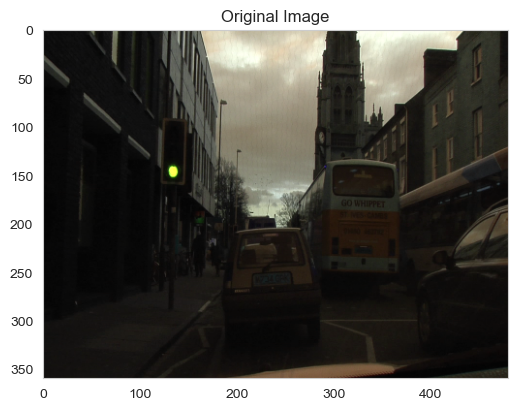

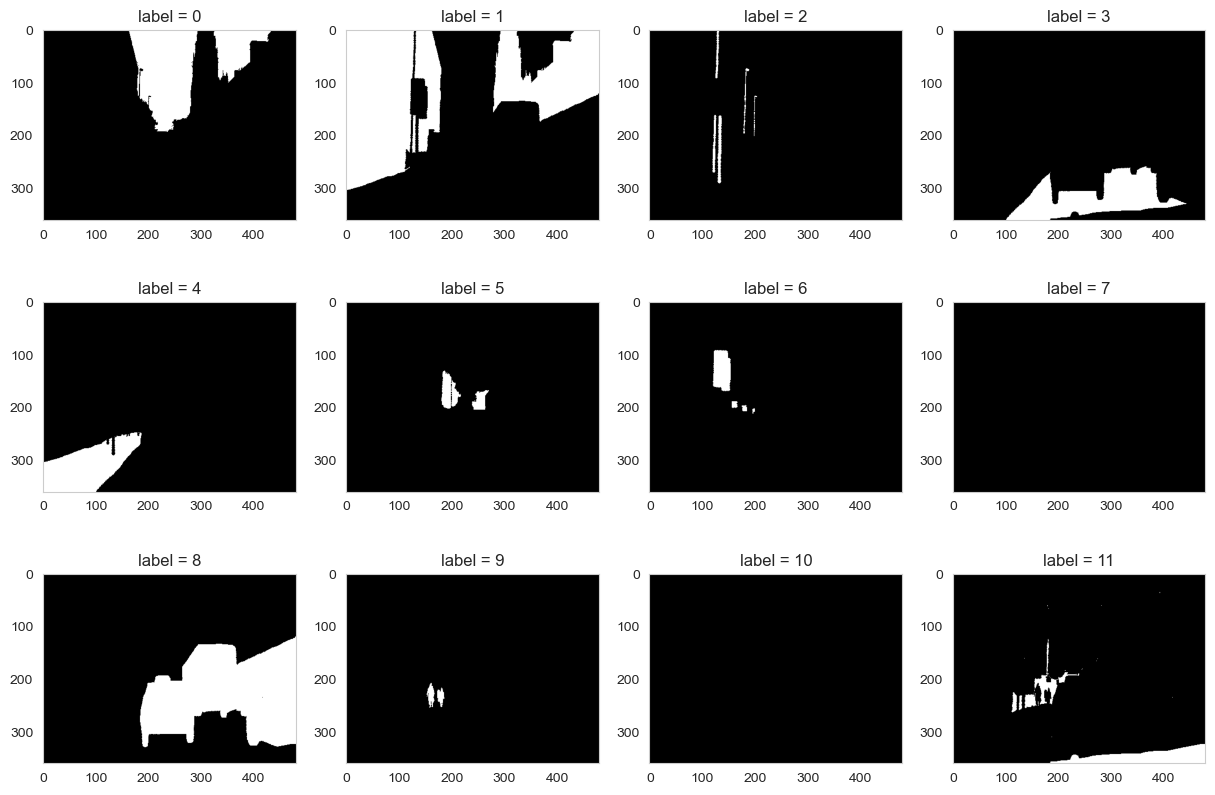

In [1]:
import cv2, os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid", {'axes.grid' : False}) # Set background white but no gridlines

# enter your path here
dir_seg = "./dataset1/annotations_prepped_train"  # annotations_prepped_train
dir_img = "./dataset1/images_prepped_train"  # images_prepped_train

ldseg = np.array(os.listdir(dir_seg)) # Lists all files in dir_seg then converts into an array

## pick the first image file
fnm = ldseg[0]
print(fnm)


## read in the original image and segmentation labels
## Read first image from annotations_prepped_train and images_prepped_train with path "dir_seg +"/"+ fnm"
## Here I used the os.path.join method
seg = cv2.imread(os.path.join(dir_seg, fnm))   # image from annotations_prepped_train (360, 480, 3)
img_is = cv2.imread(os.path.join(dir_img, fnm)) # image from images_prepped_train

print("seg.shape={}, img_is.shape={}".format(seg.shape,img_is.shape)) # Print out the size of each files


## Check the number of labels
mi, ma = np.min(seg), np.max(seg) # Read the min and max label of the first image
n_classes = ma - mi + 1 ## total number of classes, since the numbering starts at "0"
print("minimum seg = {}, maximum seg = {}, Total number of segmentation classes = {}".format(mi,ma, n_classes))

# Plot original image from images_prepped_train image:
plt.figure(figsize=(6,6))
plt.imshow(img_is)
plt.title("Original Image")
plt.show()

# Plot all class from annotations_prepped_train image:
fig = plt.figure(figsize=(15,10))
for k in range(mi,ma+1):
    ax = fig.add_subplot(3,int(np.ceil(n_classes/3)),k+1)
    ax.imshow((seg == k)*1.0)
    ax.set_title("label = {}".format(k))

plt.show()

From the first section, we can see there are 12 segmentation classes and the image is from a driving car.

Assign color to annotations_prepped_train image

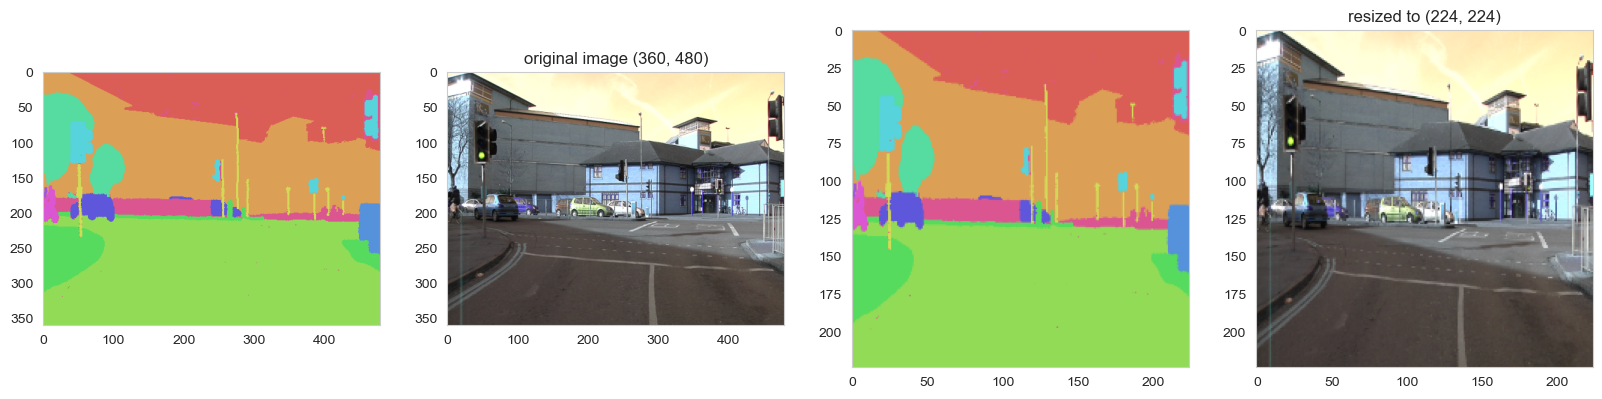

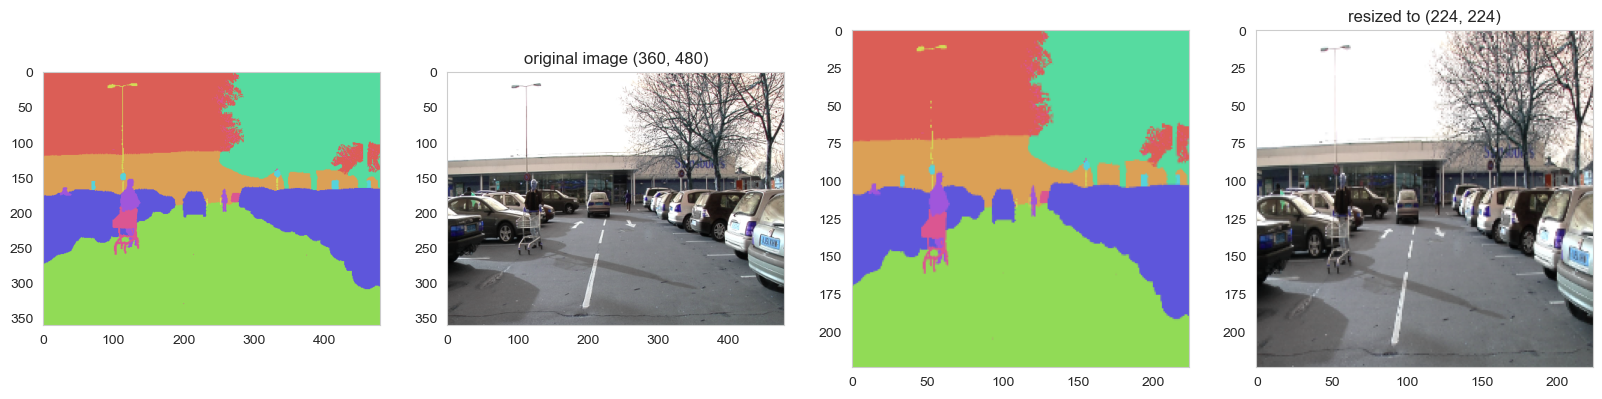

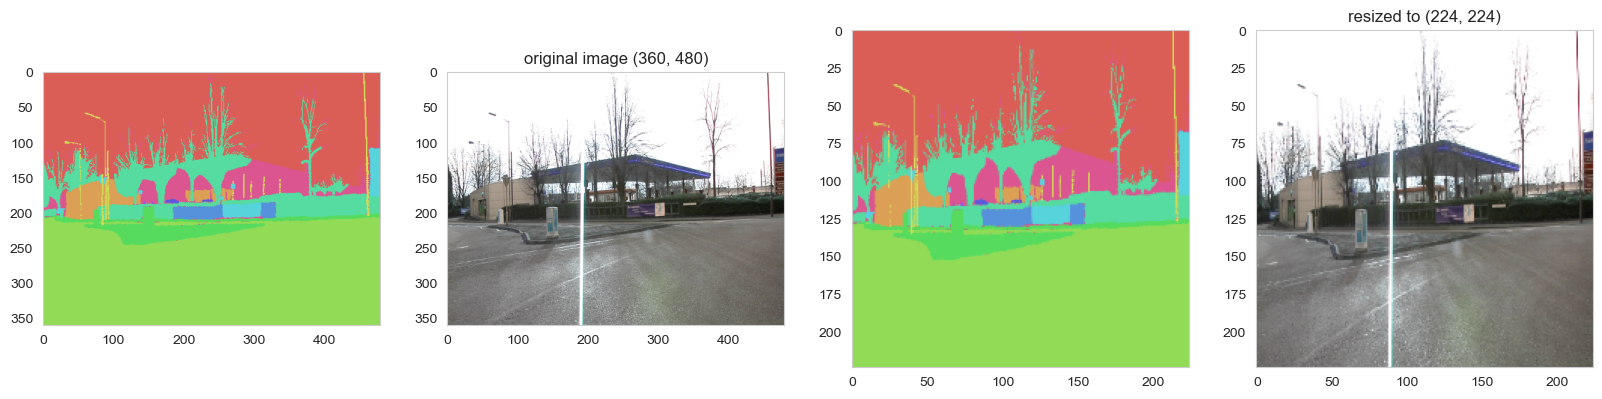

In [2]:
import random
def give_color_to_seg_img(seg,n_classes):
    '''
    seg : size is (input_width,input_height,3)
    n_classes : Number of classes
    assign color to each class 
        You can use sns color palette to assign color pattern
        colors = sns.color_palette("hls", n_classes)
    '''
    if len(seg.shape) == 3 and seg.shape[2] == 3: # Ensures the legitmacy of input
        # assume the three channels are Width, height, and color
        seg = seg[:, :, 0] # Since all pixels have the same label, only one layer is enough
    
    colors = sns.color_palette("hls", n_classes)
    seg_img = np.zeros((seg.shape[0], seg.shape[1], 3), dtype = np.uint8) # Create a new array with new colors
    
    
    for cl in range (n_classes):
        segc = (seg == cl) #creating a mask for each classes
        # print("Color Class ", cl, colors[cl])

        for i in range (3):
            seg_img[:, :, i] += (segc * (colors[cl][i] * 255)).astype('uint8')
        
    return(seg_img)

input_height , input_width = 224 , 224
output_height , output_width = 224 , 224


ldseg = np.array(os.listdir(dir_seg))
for fnm in ldseg[np.random.choice(len(ldseg),3,replace=False)]:
    # randomly select on the training image
    fnm = fnm.split(".")[0]
    seg = cv2.imread(dir_seg  +"/"+ fnm + ".png") # (360, 480, 3)
    img_is = cv2.imread(dir_img  +"/"+ fnm + ".png")
    # assign color to its annotations_prepped_train image
    seg_img = give_color_to_seg_img(seg,n_classes)

    fig = plt.figure(figsize=(20,40))
    ax = fig.add_subplot(1,4,1)
    ax.imshow(seg_img)
    
    ax = fig.add_subplot(1,4,2)
    ax.imshow(img_is/255.0)
    ax.set_title("original image {}".format(img_is.shape[:2]))
    
    ax = fig.add_subplot(1,4,3)
    ax.imshow(cv2.resize(seg_img,(input_height , input_width)))
    
    ax = fig.add_subplot(1,4,4)
    ax.imshow(cv2.resize(img_is,(output_height , output_width))/255.0)
    ax.set_title("resized to {}".format((output_height , output_width)))
    plt.show()

To simplify the problem, I will reshape all the images to the same size: (224,224). 

Since this is the iamge shape used in VGG and FCN model in this blog uses a network that takes advantage of VGG structure. The FCN model becomes easier to explain when the image shape is (224,224).

In [3]:
def getImageArr( path , width , height ):
        # Ensure the images have color
        img = cv2.imread(path, 1)
        # Normalize images before feeding to the FCN
        img = np.float32(cv2.resize(img, ( width , height ))) / 127.5 - 1
        
        return img

def getSegmentationArr( path , nClasses ,  width , height  ):
    
    seg_labels = np.zeros((  height , width  , nClasses ))
    img = cv2.imread(path, 1)
    img = cv2.resize(img, ( width , height ))
    img = img[:, : , 0]

    for c in range(nClasses):
        seg_labels[: , : , c ] = (img == c ).astype(int)
    ##seg_labels = np.reshape(seg_labels, ( width*height,nClasses  ))
    return seg_labels


images = os.listdir(dir_img)
images.sort()
segmentations  = os.listdir(dir_seg)
segmentations.sort()
    
X = []
Y = []
for im , seg in zip(images,segmentations) :
    X.append( getImageArr(dir_img +"/"+ im , input_width , input_height )  )
    Y.append( getSegmentationArr( dir_seg +"/"+ seg , n_classes , output_width , output_height )  )

X, Y = np.array(X) , np.array(Y)
print(X.shape,Y.shape)

(367, 224, 224, 3) (367, 224, 224, 12)


Import Keras and Tensorflow to develop deep learning FCN models

In [4]:
## Import usual libraries
import tensorflow as tf
import keras, sys, time, warnings
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
import pandas as pd 
warnings.filterwarnings("ignore")

###############################################

# check python, keras, and tensorflow version
print("python {}".format(sys.version))
print("keras version {}".format(keras.__version__)); del keras
print("tensorflow version {}".format(tf.__version__))


python 3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]
keras version 2.15.0
tensorflow version 2.15.0


# From classifier to dense FCN
The recent successful deep learning models such as VGG are originally designed for classification task. The network stacks convolution layers together with down-sampling layers, such as max-pooling, and then finally stacks fully connected layers. Appending a fully connected layer enables the network to learn something using global information where the spatial arrangement of the input falls away.

# Fully convosutional network
For the segmentation task, however, spatial infomation should be stored to make a pixcel-wise classification. FCN allows this by making all the layers of VGG to convolusional layers.

Fully convolutional indicates that the neural network is composed of convolutional layers without any fully-connected layers usually found at the end of the network. Fully Convolutional Networks for Semantic Segmentation motivates the use of fully convolutional networks by "convolutionalizing" popular CNN architectures e.g. VGG can also be viewed as FCN.

The following method is FCN8 from Fully Convolutional Networks for Semantic Segmentation. It deplicates VGG16 net by discarding the final classifier layer and convert all fully connected layers to convolutions. Output image size is (output_height, output_width) = (224,224).

# Upsampling
The upsampling layer brings low resolution image to high resolution. There are various upsamping methods. This presentation gives a good overview. For example, one may double the image resolution by duplicating each pixcel twice. This is so-called nearest neighbor approach and implemented in Keras's UpSampling2D.

These upsampling layers do not have weights/parameters so the model is not flexible. Instead, FCN8 uses upsampling procedure called backwards convolusion (sometimes called deconvolution) with output stride. This method simply reverses the forward and backward passes of convolution and implemented in Keras's Conv2DTranspose.

In FCN8, the upsampling layer is followed by several skip connections. See details at Fully Convolutional Networks for Semantic Segmentation.

Downloaded VGG16 weights from fchollet's Github:  
https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5

This is a massive .h5 file (57MB).

In [5]:
# location of VGG weights
VGG_Weights_path = "vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"

In [6]:
#from tensorflow.keras.models import Model
#from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, add
from tensorflow.keras.applications import VGG16

def FCN8(nClasses, input_height=224, input_width=224):
    
    print("nClasses = ", nClasses)
    
    ## input_height and width must be devisible by 32 because maxpooling with filter size = (2,2) is operated 5 times,
    ## which makes the input_height and width 2^5 = 32 times smaller
    assert input_height%32 == 0
    assert input_width%32 == 0
    IMAGE_ORDERING =  "channels_last" 
    
    img_input = Input(shape = (input_height,input_width, 3)) ## Assume 224,224,3
    
    vgg = VGG16(weights = VGG_Weights_path, include_top = False, input_tensor = img_input)
    
    # Block 1
    block1 = vgg.get_layer('block1_pool').output
    print("block1 info: ", block1, "\n")
    
    # Block 2
    block2 = vgg.get_layer('block2_pool').output
    print("block2 info: ", block2, "\n")
    
    # Block 3
    block3 = vgg.get_layer('block3_pool').output
    print("block3 info: ", block3, "\n")

    # Block 4
    block4 = vgg.get_layer('block4_pool').output
    print("block4 info: ", block4, "\n")

    # Block 5
    block5 = vgg.get_layer('block5_pool').output
    print("block5 info: ", block5, "\n")

    n = 4096
    
    # Conv6 - 7
    conv6 = Conv2D(n, (7, 7), activation = 'relu', padding = 'same')(block5)
    print("conv6 info: ", conv6, "\n")
    
    conv7 = Conv2D(n, (1, 1), activation = 'relu', padding = 'same')(conv6)
    print("conv7 info: ", conv7, "\n")
    
    ## 4 times upsampling for cov7
    conv7_x4 = Conv2DTranspose(nClasses, kernel_size = (4, 4), strides = (4, 4), use_bias = False)(conv7)
    
    ## 2 times upsampling for pool3 and 4
    pool4_x2 = Conv2DTranspose(nClasses, kernel_size = (2, 2), strides = (2, 2), use_bias = False)(block4)
    pool3 = Conv2DTranspose(nClasses, kernel_size = (1, 1), strides = (1, 1), use_bias = False)(block3)

    print("conv7_x4: ", conv7_x4, "\n")
    print("pool4_x2: ", pool4_x2, "\n")
    print("pool3: ", pool3, "\n")

    
    ## Combining the upsampls together (skip connection)
    up_conv7_pool4 = Add()([conv7_x4, pool4_x2])
    up_conv7_pool4_pool3 = Add()([up_conv7_pool4, pool3])
    
    #combine the upsampling and softmax
    final_output = Conv2DTranspose(nClasses, kernel_size=(8, 8), strides=(8, 8), use_bias=False)(up_conv7_pool4_pool3)    
    print("final_output info: ", final_output, "\n")
    
    # create model and load weight
    model = Model(inputs = img_input, outputs = Activation('softmax')(final_output))

    return model

model = FCN8(nClasses     = n_classes,  
             input_height = 224, 
             input_width  = 224)
model.summary()

nClasses =  12


block1 info:  KerasTensor(type_spec=TensorSpec(shape=(None, 112, 112, 64), dtype=tf.float32, name=None), name='block1_pool/MaxPool:0', description="created by layer 'block1_pool'") 

block2 info:  KerasTensor(type_spec=TensorSpec(shape=(None, 56, 56, 128), dtype=tf.float32, name=None), name='block2_pool/MaxPool:0', description="created by layer 'block2_pool'") 

block3 info:  KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 256), dtype=tf.float32, name=None), name='block3_pool/MaxPool:0', description="created by layer 'block3_pool'") 

block4 info:  KerasTensor(type_spec=TensorSpec(shape=(None, 14, 14, 512), dtype=tf.float32, name=None), name='block4_pool/MaxPool:0', description="created by layer 'block4_pool'") 

block5 info:  KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 512), dtype=tf.float32, name=None), name='block5_pool/MaxPool:0', description="created by layer 'block5_pool'") 

conv6 info:  KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 4096), dt

                                                                                                  
 add_1 (Add)                 (None, 28, 28, 12)           0         ['add[0][0]',                 
                                                                     'conv2d_transpose_2[0][0]']  
                                                                                                  
 conv2d_transpose_3 (Conv2D  (None, 224, 224, 12)         9216      ['add_1[0][0]']               
 Transpose)                                                                                       
                                                                                                  
 activation (Activation)     (None, 224, 224, 12)         0         ['conv2d_transpose_3[0][0]']  
                                                                                                  
Total params: 135083840 (515.30 MB)
Trainable params: 135083840 (515.30 MB)
Non-trainable params: 0 (0.00 Byt

Split between training and testing data

In [7]:
from sklearn.utils import shuffle
train_rate = 0.85
index_train = np.random.choice(X.shape[0],int(X.shape[0]*train_rate),replace=False)
index_test  = list(set(range(X.shape[0])) - set(index_train))
                            
X, Y = shuffle(X,Y)
X_train, y_train = X[index_train],Y[index_train]
X_test, y_test = X[index_test],Y[index_test]
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(311, 224, 224, 3) (311, 224, 224, 12)
(56, 224, 224, 3) (56, 224, 224, 12)


In [43]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import Callback

# Define an exponential decay learning rate schedule
initial_learning_rate = 1E-2

lr_schedule = ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

# Create an SGD optimizer with the learning rate schedule
sgd = SGD(learning_rate=lr_schedule, momentum=0.9, nesterov=True)

# Compile the model with the optimizer
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

class CustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        print(f"End of epoch {epoch + 1}. Loss: {logs.get('loss')}, Accuracy: {logs.get('accuracy')}")

# Path to the weights file
ST_weights_path = 'FCN8_Trained_Weights.h5'

# Check if weights file exists
if os.path.exists(ST_weights_path):
    print("Loading previously saved weights...\n")
    model.load_weights(ST_weights_path)        
        
# Fit the model with the custom callback
hist1 = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=200, verbose=1, callbacks=[CustomCallback()])

model.save_weights(ST_weights_path)
print("\nNewly trained weights saved.")


Loading previously saved weights...

Epoch 1/100
10/10 [==============================] - 231s 21s/step - loss: 0.3189 - accuracy: 0.9111 - val_loss: 0.4297 - val_accuracy: 0.8747
Epoch 2/100
10/10 [==============================] - 211s 21s/step - loss: 0.3190 - accuracy: 0.9109 - val_loss: 0.4167 - val_accuracy: 0.8799
Epoch 3/100
10/10 [==============================] - 203s 20s/step - loss: 0.3150 - accuracy: 0.9121 - val_loss: 0.4454 - val_accuracy: 0.8724
Epoch 4/100
10/10 [==============================] - 202s 20s/step - loss: 0.3243 - accuracy: 0.9088 - val_loss: 0.4171 - val_accuracy: 0.8802
Epoch 5/100
10/10 [==============================] - 204s 20s/step - loss: 0.3135 - accuracy: 0.9127 - val_loss: 0.4208 - val_accuracy: 0.8782
Epoch 6/100
10/10 [==============================] - 204s 20s/step - loss: 0.3325 - accuracy: 0.9068 - val_loss: 0.4269 - val_accuracy: 0.8757
Epoch 7/100
10/10 [==============================] - 202s 20s/step - loss: 0.3145 - accuracy: 0.9125 - va

Epoch 29/100
10/10 [==============================] - 207s 21s/step - loss: 0.2977 - accuracy: 0.9175 - val_loss: 0.4236 - val_accuracy: 0.8808
Epoch 30/100
10/10 [==============================] - 203s 20s/step - loss: 0.3073 - accuracy: 0.9144 - val_loss: 0.4362 - val_accuracy: 0.8777
Epoch 31/100
10/10 [==============================] - 199s 20s/step - loss: 0.3008 - accuracy: 0.9163 - val_loss: 0.4174 - val_accuracy: 0.8813
Epoch 32/100
10/10 [==============================] - 202s 20s/step - loss: 0.3000 - accuracy: 0.9162 - val_loss: 0.4240 - val_accuracy: 0.8778
Epoch 33/100
10/10 [==============================] - 216s 22s/step - loss: 0.3080 - accuracy: 0.9135 - val_loss: 0.4169 - val_accuracy: 0.8804
Epoch 34/100
10/10 [==============================] - 212s 21s/step - loss: 0.2926 - accuracy: 0.9191 - val_loss: 0.4432 - val_accuracy: 0.8691
Epoch 35/100
10/10 [==============================] - 210s 21s/step - loss: 0.2979 - accuracy: 0.9172 - val_loss: 0.4247 - val_accuracy:

Epoch 57/100
10/10 [==============================] - 227s 23s/step - loss: 0.2798 - accuracy: 0.9226 - val_loss: 0.4296 - val_accuracy: 0.8776
Epoch 58/100
10/10 [==============================] - 232s 23s/step - loss: 0.2797 - accuracy: 0.9225 - val_loss: 0.4240 - val_accuracy: 0.8815
Epoch 59/100
10/10 [==============================] - 216s 22s/step - loss: 0.2860 - accuracy: 0.9203 - val_loss: 0.4288 - val_accuracy: 0.8807
Epoch 60/100
10/10 [==============================] - 219s 22s/step - loss: 0.2795 - accuracy: 0.9225 - val_loss: 0.4270 - val_accuracy: 0.8784
Epoch 61/100
10/10 [==============================] - 223s 23s/step - loss: 0.2807 - accuracy: 0.9222 - val_loss: 0.4339 - val_accuracy: 0.8780
Epoch 62/100
10/10 [==============================] - 219s 22s/step - loss: 0.2796 - accuracy: 0.9222 - val_loss: 0.4298 - val_accuracy: 0.8792
Epoch 63/100
10/10 [==============================] - 228s 23s/step - loss: 0.2816 - accuracy: 0.9215 - val_loss: 0.4283 - val_accuracy:

Epoch 85/100
10/10 [==============================] - 227s 23s/step - loss: 0.2656 - accuracy: 0.9263 - val_loss: 0.4354 - val_accuracy: 0.8794
Epoch 86/100
10/10 [==============================] - 226s 23s/step - loss: 0.2726 - accuracy: 0.9240 - val_loss: 0.4319 - val_accuracy: 0.8785
Epoch 87/100
10/10 [==============================] - 231s 23s/step - loss: 0.2690 - accuracy: 0.9252 - val_loss: 0.4545 - val_accuracy: 0.8705
Epoch 88/100
10/10 [==============================] - 217s 22s/step - loss: 0.2886 - accuracy: 0.9190 - val_loss: 0.4258 - val_accuracy: 0.8812
Epoch 89/100
10/10 [==============================] - 228s 23s/step - loss: 0.2628 - accuracy: 0.9273 - val_loss: 0.4284 - val_accuracy: 0.8804
Epoch 90/100
10/10 [==============================] - 215s 21s/step - loss: 0.2621 - accuracy: 0.9274 - val_loss: 0.4559 - val_accuracy: 0.8770
Epoch 91/100
10/10 [==============================] - 215s 22s/step - loss: 0.2751 - accuracy: 0.9230 - val_loss: 0.4422 - val_accuracy:

2/2 [==============================] - 7s 3s/step - loss: 0.4319 - accuracy: 0.8804

 Test Accuracy: 0.8803607821464539, 
 Test Loss: 0.43193745613098145
2/2 [==============================] - 10s 5s/step
Mean IoU: 0.8586769694971956
2/2 [==============================] - 10s 4s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


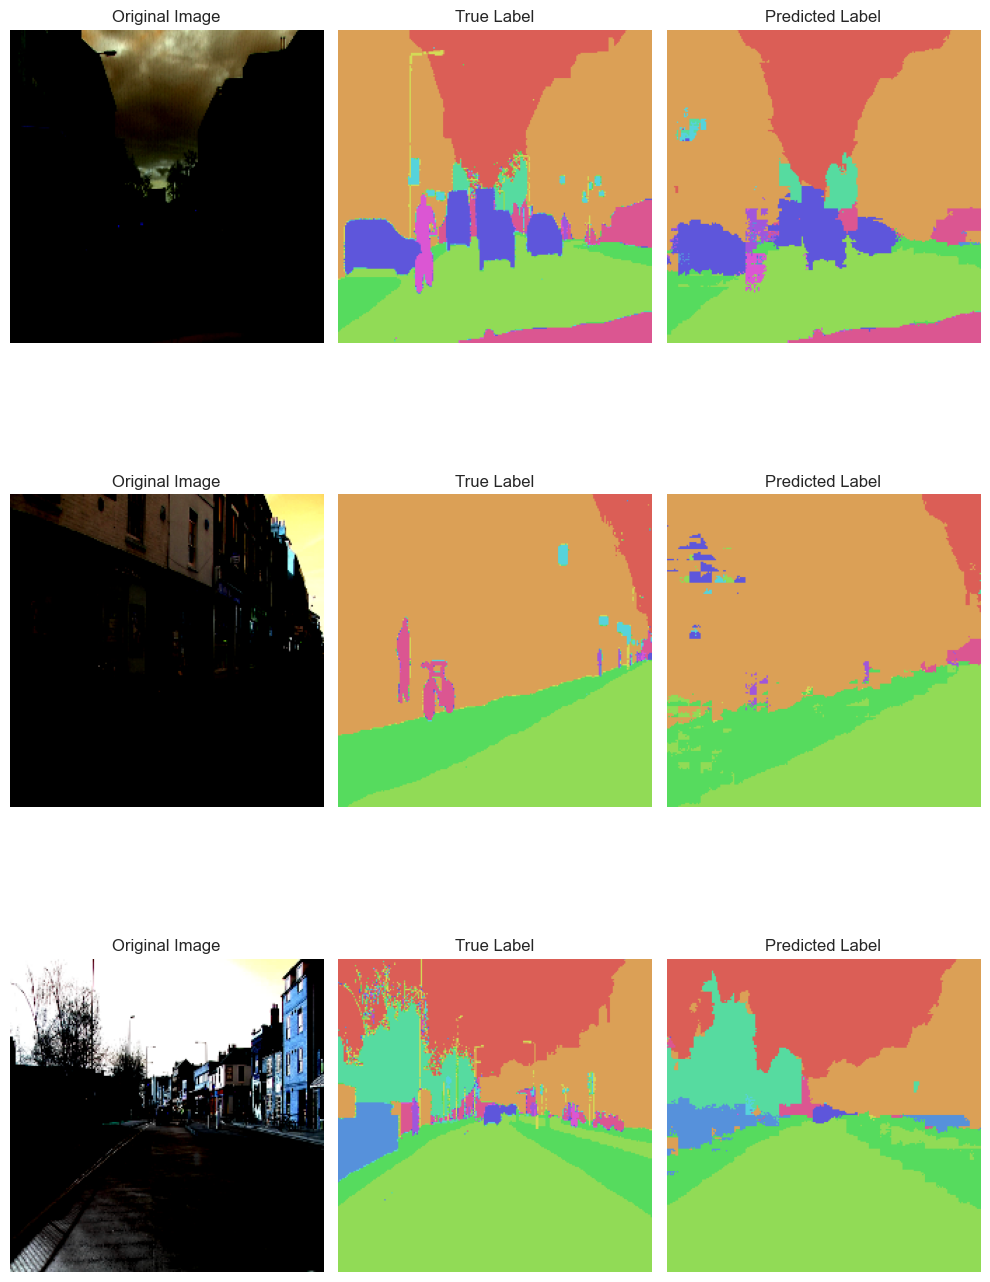

In [46]:
from tensorflow.keras.models import load_model

# Load the saved model weights
# The path is previously defined (ST_weights_path)
model.load_weights(ST_weights_path)

# Known test data: X_test, y_test
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"\n Test Accuracy: {test_accuracy}, \n Test Loss: {test_loss}")

# Define the number of classes in your dataset
num_classes = np.unique(Y).shape[0]

# Function to calculate IoU for a single class
def calculate_iou(y_true, y_pred_softmax, class_id):
    y_pred = np.argmax(y_pred_softmax, axis=-1)  # Convert softmax output to single class prediction
    true_class = y_true[..., class_id] == 1      # True for pixels belonging to the class
    pred_class = y_pred == class_id              # True for pixels predicted to belong to the class

    intersection = np.logical_and(true_class, pred_class)
    union = np.logical_or(true_class, pred_class)
    iou = np.sum(intersection) / np.sum(union) if np.sum(union) != 0 else 0
    return iou

# Calculate IoU for each class
predictions = model.predict(X_test)
iou_values = [calculate_iou(y_test, predictions, class_id) for class_id in range(num_classes)]

# Calculate mean IoU
mean_iou = np.mean([iou for iou in iou_values if iou is not None])
print(f"Mean IoU: {mean_iou}")


# Visualizing model predictions: 
def visualize_predictions(X, y_true, y_pred, n_classes, num_display=3):
    plt.figure(figsize=(10, num_display * 5))

    # Generate random indices
    random_indices = np.random.choice(X.shape[0], num_display, replace=False)
    
    for idx, i in enumerate(random_indices):
        img = X[i]
        true_label = np.argmax(y_true[i], axis=-1)
        pred_label = np.argmax(y_pred[i], axis=-1)

        true_label_colored = give_color_to_seg_img(true_label, n_classes)
        pred_label_colored = give_color_to_seg_img(pred_label, n_classes)

        plt.subplot(num_display, 3, idx * 3 + 1)
        plt.imshow(img)
        plt.title("Original Image")
        plt.axis('off')

        plt.subplot(num_display, 3, idx * 3 + 2)
        plt.imshow(true_label_colored)
        plt.title("True Label")
        plt.axis('off')

        plt.subplot(num_display, 3, idx * 3 + 3)
        plt.imshow(pred_label_colored)
        plt.title("Predicted Label")
        plt.axis('off')

    plt.tight_layout()
    plt.show()
    
# Make predictions with the model
predictions = model.predict(X_test)

# Visualize the predictions
visualize_predictions(X_test, y_test, predictions, n_classes, num_display=3)
